<a href="https://colab.research.google.com/github/CodeBeckZero/MADDQN/blob/main/colab_timesnet_work_bench.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Context

Exploring TimesNet, latest advance in Time-Series Forecasting, using Marco Peixerio's medium article to get started

[Medium Article about TmesNet](https://medium.com/towards-data-science/timesnet-the-latest-advance-in-time-series-forecasting-745b69068c9c)

# Enviorment Setup

## Installation of Packages

In [ ]:
!pip install neuralforecast

## Libraries

In [ ]:
!wget -O /content/cleandata.py https://raw.githubusercontent.com//CodeBeckZero/MADDQN/main/utilities/cleandata.py
!wget -O /content/cleandata.py https://raw.githubusercontent.com//CodeBeckZero/MADDQN/main/utilities/data.py


import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt
from utilities.data import RunningWindowDataset, DateTimeSlidingWindowDataset
from environments.stockenv import ContinuousOHLCVEnv
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from neuralforecast.core import NeuralForecast
from neuralforecast.models import TimesNet
from neuralforecast.losses.numpy import mae, mse
from datetime import datetime
from utilities.cleandata import YAHOO_csv_input



def set_seed(seed):
    """Set seed for reproducibility."""
    # Python random module
    random.seed(seed)

    # NumPy
    np.random.seed(seed)

    # PyTorch
    torch.manual_seed(seed)

    # If you are using CUDA
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
        # Additional settings to force determinism in your operations:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False


--2024-04-21 16:43:53--  https://raw.githubusercontent.com//CodeBeckZero/MADDQN/main/cleandata.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /CodeBeckZero/MADDQN/main/cleandata.py [following]
--2024-04-21 16:43:53--  https://raw.githubusercontent.com/CodeBeckZero/MADDQN/main/cleandata.py
Reusing existing connection to raw.githubusercontent.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 8830 (8.6K) [text/plain]
Saving to: ‘/content/cleandata.py’

/content/cleandata. 100%[===================>]   8.62K  --.-KB/s    in 0s      

2024-04-21 16:43:53 (65.3 MB/s) - ‘/content/cleandata.py’ saved [8830/8830]



In [ ]:
# Set a fixed seed for all libraries
set_seed(42)


input_url = 'https://raw.githubusercontent.com/CodeBeckZero/MADDQN/main/input_data'
stock_inputs ={'DJI':'^DJI_daily.csv',
               'NDAQ': '^IXIC_daily.csv',
               'SP500': '^SPX_daily.csv',
               'AAPL': 'AAPL_daily.csv',
               'AMZN': 'AMZN_daily.csv',
               'GOOGL': 'GOOGL_daily.csv',
               'MSFT': 'MSFT_daily.csv',
               'SINE': 'sine_wave_daily.csv',
               'FORD': 'F_daily.csv',
               'JNJ': 'JNJ_daily.csv',
               'NEE': 'NEE_daily.csv',
               'PFE': 'PFE_daily.csv',
               'TSLA': 'TSLA_daily.csv'}

# Training Inputs
trn_keys = ['AAPL']
training_range = ('2007-01-03','2007-12-29')
trn_dt_range = [datetime.strptime(dt_str, "%Y-%m-%d") for dt_str in training_range]

# Validation Inputs
val_keys = trn_keys
validation_range = ('2021-01-04','2021-12-31')
val_dt_range = [datetime.strptime(dt_str, "%Y-%m-%d") for dt_str in validation_range]

# Testing Inputs
tst_keys = trn_keys
testing_range = ('2008-01-02','2008-02-29')
tst_dt_range = [datetime.strptime(dt_str, "%Y-%m-%d") for dt_str in testing_range]

window_size = 250
columns = ['open','high','low','close']

env = {}

for name, file in stock_inputs.items():
    if name in set(trn_keys + val_keys + tst_keys):
        df_ohlcv = YAHOO_csv_input(file, input_url)
        rw_datatime = DateTimeSlidingWindowDataset(df_ohlcv['date'],window_size)
        rw_ohlc_data = RunningWindowDataset(df_ohlcv[columns],window_size)
        rw_closing_price = RunningWindowDataset(df_ohlcv[['close']],window_size)
        temp = {'data': rw_ohlc_data, 'price':rw_closing_price, 'date':rw_datatime}
        env[name] = temp






# Preprocessing

In [ ]:
df = pd.DataFrame(env['AAPL']['data'][0], columns= columns)
df['date'] = env['AAPL']['date'][0]
df_by_value = {}

value_names = [col for col in df.columns if col != 'date']

for value in value_names:
    # Selecting columns 'date' and 'value_column' for the new DataFrame
    new_df = df[['date', value]].copy()

    # Renaming columns 'date' to 'ds' and 'value_column' to 'y'
    new_df = new_df.rename(columns={'date': 'ds', value: 'y'})

    # Adding a 'unique_id' column to the new DataFrame
    new_df.insert(1,'unique_id',value)

    # Store the updated DataFrame in the dictionary
    df_by_value[value] = new_df

    long_df = pd.concat(df_by_value.values(),axis=0, ignore_index=True)


,ds,unique_id,y
4808,2009-02-11,high,-1.226419
13694,2010-06-08,close,-0.970445
4634,2008-06-04,high,-0.836726
14803,2014-10-31,close,0.017689
14585,2013-12-19,close,-0.212298


,ds,unique_id,y
12267,2021-10-01,low,3.952292
7900,2021-05-25,high,3.648703
12187,2021-06-09,low,3.783367
8036,2021-12-07,high,4.434961
20657,2021-02-08,volume,9.138547


,ds,unique_id,y
3994,2022-11-11,open,2.627188
16655,2022-03-11,close,3.316488
20904,2022-01-31,volume,4.232076
8536,2023-12-04,high,3.826955
8552,2023-12-27,high,4.192964


## Visualization

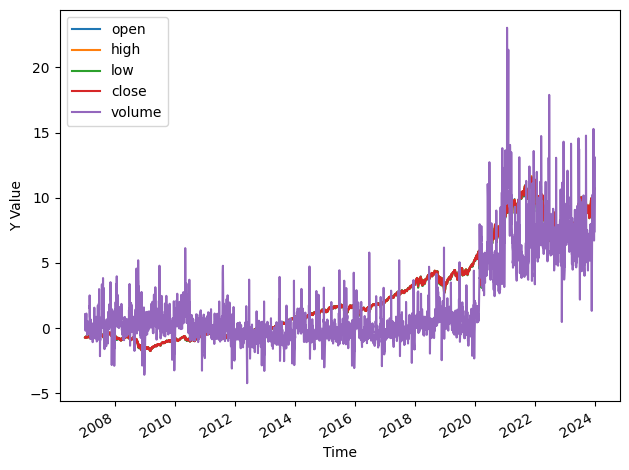

In [ ]:
fig, ax = plt.subplots()

for value in value_names:
  ax.plot(df_by_value[value]['ds'], df_by_value[value]['y'], label=value)

ax.set_xlabel('Time')
ax.set_ylabel('Y Value')

# Add legend to distinguish between different values
ax.legend()

# Rotate and align x-axis labels
fig.autofmt_xdate()

# Adjust layout to prevent overlapping labels
plt.tight_layout()

# Show the plot
plt.show()

# Modelling

In [ ]:
timesnet_config= {
    "input_size": 100,      # Length of input window
    "hidden_size": 256,     # Size of embedding for embedding and encoders,
    "encoder_layers": 3,                    # num of encoders
    "learning_rate": 0.0008,            # Initial Learning rate
    "batch_size": 5,                                          # Number of series in batch
    'dropout': 0.1,                                           # Dropout for embeddings
    'conv_hidden_size' : 5,                                   # Channels for the inception block
    'top_k' : 5,                                              # Top num of periods from FFT considered
    'num_kernels' : 13,                 # Number of Filters
    'max_steps' : 100,                 # Number of Training Steps
    'early_stop_patience_steps' : 10,  # early stoppage on validation
    'val_check_steps' : 5,             # Val check every X steps,
    'windows_batch_size' : 60,         # Number of windows in training epoch
    'valid_batch_size' : 60
}


model = TimesNet(h = y_horizon, # Forecast horizon
                 input_size = batch_len, # Length of input window (lags)
                 hidden_size = 64, # Size of embedding for embedding and encoders,
                 dropout = 0.1, # Dropout for embeddings
                 conv_hidden_size = 5, # Channels for the inception block
                 top_k = 5, # Top num of periods from FFT considered
                 num_kernels = 13, # number of kernels for the inception block
                 encoder_layers = 3, # num of encoders
                 max_steps = 100, # of training steps
                 early_stop_patience_steps = -1, #early stoppage on validation
                 val_check_steps = 5, # Val check every X steps,
                 windows_batch_size = 64, # Number of windows in training epoch,
                 learning_rate = 0.0008)



/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
INFO:lightning_fabric.utilities.seed:Seed set to 1


## Training

In [ ]:
nf = NeuralForecast(models=[model], freq='d')
nf.fit(df=trn_envs['NDAQ'])



INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type          | Params
-------------------------------------------------
0 | loss           | MAE           | 0     
1 | padder_train   | ConstantPad1d | 0     
2 | scaler         | TemporalNorm  | 0     
3 | model          | ModuleList    | 5.6 M 
4 | enc_embedding  | DataEmbedding | 192   
5 | layer_norm     | LayerNorm     | 128   
6 | predict_linear | Linear        | 82.2 K
7 | projection     | Linear        | 65    
-------------------------------------------------
5.7 M     Trainable params
0         Non-trainabl

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 5. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.


AttributeError: 'TimesNet' object has no attribute 'results'

In [ ]:
test_df = pd.DataFrame(df_by_value['close'][validation_range[0]:testing_range[1]])
forecast = nf.predict(df=test_df)

/usr/local/lib/python3.10/dist-packages/neuralforecast/tsdataset.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.temporal = torch.tensor(temporal, dtype=torch.float)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:184: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


                  ds  TimesNet
unique_id                     
close     2018-11-30  3.641212
close     2018-12-01  3.655835
close     2018-12-02  3.877373
close     2018-12-03  3.643878
close     2018-12-04  3.848867
...              ...       ...
close     2020-04-08  5.874259
close     2020-04-09  5.932225
close     2020-04-10  5.995364
close     2020-04-11  5.912675
close     2020-04-12  5.919146

[500 rows x 2 columns]


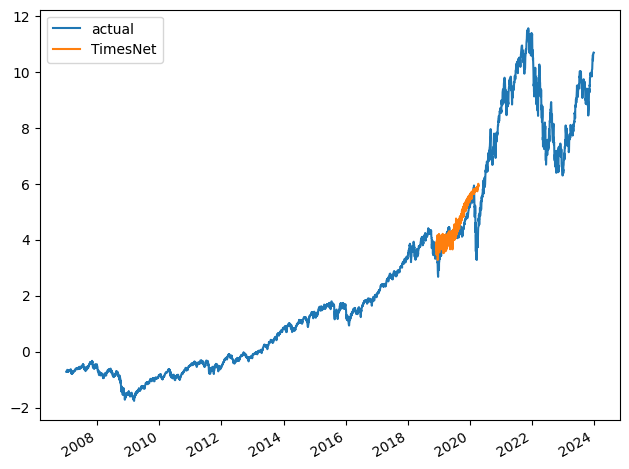

In [ ]:
print(forecast)
fig, ax = plt.subplots()

ax.plot(df_by_value['close']['ds'], df_by_value['close']['y'], label='actual')
ax.plot(forecast['ds'],forecast['TimesNet'], label='TimesNet')


ax.legend(loc='best')


fig.autofmt_xdate()
plt.tight_layout()

## Predictions

## Evaluation

In [ ]:
data = {'N-HiTS': [mae(preds_df['NHITS'], preds_df['y']), mse(preds_df['NHITS'], preds_df['y'])],
       'N-BEATS': [mae(preds_df['NBEATS'], preds_df['y']), mse(preds_df['NBEATS'], preds_df['y'])],
       'TimesNet': [mae(preds_df['TimesNet'], preds_df['y']), mse(preds_df['TimesNet'], preds_df['y'])]}

metrics_df = pd.DataFrame(data=data)
metrics_df.index = ['mae', 'mse']

metrics_df.style.highlight_min(color='lightgreen', axis=1)

,N-HiTS,N-BEATS,TimesNet
mae,1.675473,1.709744,1.704218
mse,5.088322,5.183072,4.753832
